In [229]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pyproj import CRS, Proj, transform

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot

from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, mean_absolute_error, mean_squared_error, recall_score, precision_score, roc_auc_score

In [5]:
sns.set()

plt.rcParams['figure.figsize'] = (12, 8)


In [6]:
df = pd.read_excel("counter_data.xlsx")

In [7]:
df = df[['CounterReadingID', 'StartTime', 'EndTime', 'Visits', 'CounterID_ASTA', 'ASTA_Counters.RegionalUnit', 'PAVE_Counters.CoordinateNorth', 'PAVE_Counters.CoordinateEast']]
df.columns = ['id', 'start', 'end', 'visits', 'counter', 'park', 'north', 'east']

df = df.dropna()
df['duration'] = df.end - df.start

df = df.astype({"visits": int, "counter": int, "park": int, 'north': int, 'east': int})

In [8]:
weather = pd.read_csv('weather_finland.csv')

weather.columns = ['year', 'month', 'day', 'hh:mm', 'time zone', 'clouds', 'humidity', 'precipitation', 'snow', 'temp', 'wind']

hhmm = weather['hh:mm'].str.split(":", n = 1, expand = True) 
weather['hh'] = hhmm[0]
weather['mm'] = hhmm[1]

weather['start'] = weather.apply(lambda x: pd.Timestamp(int(x[0]), int(x[1]), int(x[2]), int(x[11]), int(x[12])), 1)

In [9]:
w = weather[['start', 'clouds', 'humidity', 'precipitation', 'snow', 'temp', 'wind']]
w = w.dropna()
w = w.resample('12h', on='start').mean()[['clouds', 'humidity', 'precipitation', 'snow', 'temp', 'wind']]

In [111]:
forecast = pd.read_csv('forecast.csv')
forecast.columns = ['year', 'month', 'day', 'hh:mm', 'time zone', 'clouds', 'humidity', 'precipitation', 'snow', 'temp', 'wind']

hhmm = forecast['hh:mm'].str.split(":", n = 1, expand = True) 
forecast['hh'] = hhmm[0]
forecast['mm'] = hhmm[1]

forecast['start'] = forecast.apply(lambda x: pd.Timestamp(int(x[0]), int(x[1]), int(x[2]), int(x[11]), int(x[12])), 1)

In [122]:
forecast = forecast.drop(columns=['year', 'month', 'day', 'hh:mm', 'time zone', 'hh', 'mm'])

In [125]:
forecast = forecast.resample('12h', on='start').mean()

In [126]:
forecast.to_csv('forecast_clean.csv')

In [10]:
df_hourly = df[(df.duration == np.timedelta64(1, 'h')) & (df.park == 625)].sort_values('start')
df_counters = df_hourly.resample('12h', on='start').sum()[['visits']]  # only daily data in Nuuksio

In [19]:
tmp = pd.merge(df_counters, w, on='start', how='inner')
c = pd.merge(tmp, df_hourly[['id', 'start', 'counter', 'park', 'north', 'east']], on='start', how='inner')
c = c.dropna()

In [20]:
df_flat = pd.DataFrame(c.to_records())

In [28]:
#df_hourly = c[(c.duration == np.timedelta64(1, 'h')) & (c.park == 625)].sort_values('start')

In [29]:
#df_counters = df_hourly.groupby('counter').resample('6h', on='start').sum()[['visits']]  # only daily data in Nuuksio

In [30]:
#medians = df_flat.groupby('counter').median()['visits']

In [135]:
quantile1 = df_flat.groupby('counter').quantile(.25)['visits']
quantile2 = df_flat.groupby('counter').quantile(.5)['visits']
quantile3 = df_flat.groupby('counter').quantile(.75)['visits']

In [249]:
df_flat['week_day'] = df_flat.start.dt.dayofweek
df_flat['weekend'] = df_flat.week_day.isin([5, 6]).astype(int)
df_flat['month'] = df_flat.start.dt.month
df_flat['day'] = df_flat.start.dt.day
df_flat['hour'] = df_flat.start.dt.hour


df_flat = df_flat.sort_values(by=['start'])
df_flat['counter_busy'] = df_flat.apply(lambda x: 
                                        (x[2] > quantile2[x[10]]).astype(int) +
                                        (x[2] > quantile2[x[10]]).astype(int) + 
                                        (x[2] > quantile2[x[10]]).astype(int)
                                        , 1)
                                        

# df_flat['busy'] += (df_flat['visits'] > df_flat['visits'].quantile(0.25)).astype(int)
# df_flat['busy'] += (df_flat['visits'] > df_flat['visits'].quantile(0.5)).astype(int)
# df_flat['busy'] += (df_flat['visits'] > df_flat['visits'].quantile(0.75)).astype(int)
#df_flat['counter_busy'] = df_flat.apply(lambda x: x[4] > medians[x[5]], 1).astype(int)

In [250]:
# df_flat['week_day'] = df_flat.start.dt.dayofweek
# df_flat['weekend'] = df_flat.week_day.isin([5, 6]).astype(int)
# df_flat['month'] = df_flat.start.dt.month
# df_flat['day'] = df_flat.start.dt.day
# df_flat['hour'] = df_flat.start.dt.hour


# df_flat = df_flat.sort_values(by=['start'])
df_flat['busy'] = 0
# df_flat['busy'] += (df_flat['visits'] > df_flat['visits'].quantile(0.25)).astype(int)
df_flat['busy'] += (df_flat['visits'] > df_flat['visits'].quantile(0.5)).astype(int)
# df_flat['busy'] += (df_flat['visits'] > df_flat['visits'].quantile(0.75)).astype(int)
#df_flat['counter_busy'] = df_flat.apply(lambda x: x[4] > medians[x[5]], 1).astype(int)

# FEATURES:

1. Day of the week
2. Month
3. Day number
4. Temp

In [251]:
df_flat = df_flat[df_flat.visits > 0]

In [252]:
threshold = pd.datetime(2019, 2, 1)

df_train = df_flat[df_flat.start < threshold]
df_test = df_flat[df_flat.start >= threshold]

In [253]:
print(df_train.shape)
print(df_test.shape)

(11482, 21)
(2931, 21)


In [254]:
x_train = df_train[['month', 'weekend', 'week_day', 'day', 'hour', 'counter', 'precipitation', 'temp']].values
x_test = df_test[['month', 'weekend', 'week_day', 'day', 'hour', 'counter', 'precipitation', 'temp']].values
y_train = df_train[['busy']].values.ravel()
y_test = df_test[['busy']].values.ravel()

# x_train, x_test, y_train, y_test = train_test_split(x_data, y_data)

# clf = DecisionTreeClassifier(min_samples_split=1)
clf = RandomForestClassifier(n_estimators=10, max_depth=10)
# clf = ExtraTreesClassifier(n_estimators=3)
clf.fit(x_train, y_train)
clf.score(x_test, y_test)

clf.feature_importances_

array([0.13957449, 0.12734744, 0.09027456, 0.07373551, 0.27448123,
       0.00823614, 0.06782249, 0.21852814])

In [255]:
x_train = df_train[['month', 'weekend', 'week_day', 'day', 'hour', 'counter']].values
x_test = df_test[['month', 'weekend', 'week_day', 'day', 'hour', 'counter']].values
y_train = df_train[['busy']].values.ravel()
y_test = df_test[['busy']].values.ravel()

# x_train, x_test, y_train, y_test = train_test_split(x_data, y_data)

# clf = DecisionTreeClassifier(min_samples_split=1)
clf = RandomForestRegressor(n_estimators=100, max_depth=10)
# clf = ExtraTreesClassifier(n_estimators=3)
clf.fit(x_train, y_train)
clf.score(x_test, y_test)

clf.feature_importances_

array([0.31643077, 0.08866547, 0.15297524, 0.20360092, 0.23200997,
       0.00631763])

In [241]:
clf.feature_importances_

array([0.14663316, 0.06741671, 0.12067829, 0.10586661, 0.19961329,
       0.01307695, 0.10118466, 0.24553032])

In [128]:
import joblib

In [228]:
joblib.dump(clf, 'weather_pred_relative.joblib')

['weather_pred_relative.joblib']

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



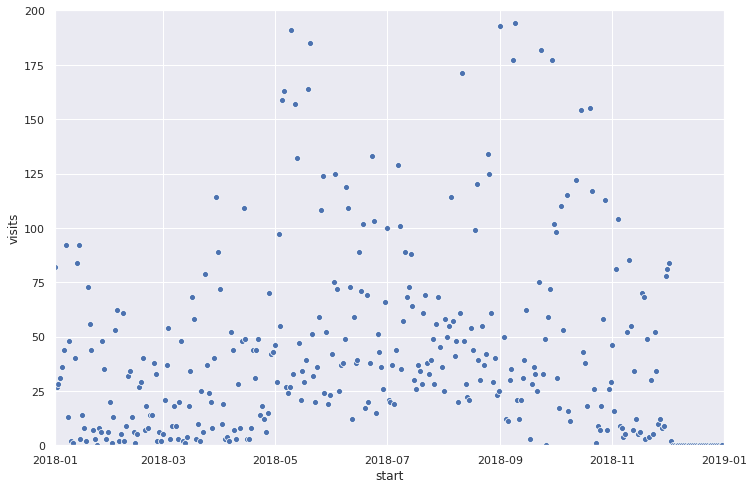

(365, 1)

In [23]:
idx = 0  # 0..5
year_start = 2018
year_end = year_start + 1

counter_id = counter_ids[idx]

df_plot = df_counters[df_counters.index.get_level_values('start') < pd.datetime(year_end, 1, 1)]
df_plot = df_plot[pd.datetime(year_start, 1, 1) <= df_plot.index.get_level_values('start')]

sns.scatterplot(x=df_plot.loc[counter_id].index, y='visits', data=df_plot.loc[counter_id])
plt.xlim(pd.datetime(year_start, 1, 1), pd.datetime(year_end, 1, 1))
plt.ylim(0, 200)
plt.show()
df_plot.loc[counter_id].shape

In [24]:
coords = df_hourly.apply(lambda x: (x[7], x[6]), axis=1).unique()

In [25]:
# Coordinate conversion template
crs = CRS.from_epsg(3067)

in_proj = Proj('epsg:3067')
out_proj = Proj('merc')

# x, y = transform(in_proj, out_proj, df_hourly.east.values[1000], df_hourly.north.values[1000])

# x, y

In [26]:
merc_coords = []
for east, north in coords:
    merc_coords.append(transform(in_proj, out_proj, east, north))

In [27]:
merc_coords

[(60.303525451006834, 24.550391008969527),
 (60.33073081360451, 24.492838046488888),
 (60.27581963490531, 24.46368928427852),
 (60.326924542956334, 24.495358359272675),
 (60.29819039594651, 24.45628974906327),
 (60.28242199633351, 24.505873789599413)]